## 📊 HR Retention Prediction — Scenario B (Full Notebook Submission)

This notebook contains **all analysis, code and commentary** required by the brief.  
Write‑ups are provided in **Markdown cells** like this one (not code).  
Replace or extend the text with your own words if you wish.

---
## 1. Introduction (Markdown)

### Application of Data Science in HR Retention
Data science enables HR teams to **predict employee attrition** and act early. Patterns in satisfaction, workload, tenure, pay and progression can signal risk, allowing targeted retention actions and reduced recruitment costs.

### Dataset & Objective
We use an HR retention CSV to predict whether an employee will **leave (1)** or **stay (0)** — the target is `Attrition` (or a close variant detected below).

### Tools & Environment
- **Anaconda** for environment + package management  
- **Jupyter Notebook** for reproducible analysis (code + narrative)  
- **Python** libraries: `pandas`, `numpy`, `matplotlib`, `scikit‑learn`

### Algorithms Compared
- **Logistic Regression** (baseline, interpretable)  
- **Decision Tree** (non‑linear, human‑readable rules)  
- **Random Forest** (ensemble; robust, often best F1)

---
## 2. Setup & Load Dataset (Code)

Edit `dataset_path` if needed, then run this cell to load and preview the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

dataset_path = r"C:/Users/JackM/Downloads/HR_Retention.csv"
print("Attempting to load:", dataset_path)
try:
    df = pd.read_csv(dataset_path)
except FileNotFoundError as e:
    raise FileNotFoundError(f"CSV not found at {dataset_path}. Update dataset_path to your actual file location.") from e


print("✅ Loaded! Shape:", df.shape)
display(df.head())
print("\nColumns:", list(df.columns))


Attempting to load: C:/Users/JackM/Downloads/HR_Retention.csv
✅ Loaded! Shape: (15001, 10)


,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2.0,157,3.0,No,Yes,No,sales,low
1,0.80,0.86,5.0,262,6.0,No,Yes,No,sales,medium
2,0.11,0.88,7.0,272,4.0,No,Yes,No,sales,medium
3,0.72,0.87,5.0,223,5.0,No,Yes,No,sales,low
4,0.37,0.52,2.0,159,3.0,No,Yes,No,sales,low



Columns: ['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'time_spend_company', 'Work_accident', 'left', 'promotion_last_5years', 'Department', 'salary']


---
## 3. Understanding the Data (Markdown + Code)

We inspect dtypes, summary stats and missing values to understand structure and quality.

In [2]:
# 3️⃣ Updated Data Overview & Missing Values Check

print("🔍 DataFrame Info:")
df_info = df.info()
print("\n")

# Descriptive statistics for all columns (numeric + categorical)
print("📈 Summary Statistics:")
summary = df.describe(include='all').T.round(3)
display(summary)

# Missing values per column
missing = df.isnull().sum().sort_values(ascending=False)
print("\n🧩 Missing Values per Column:")
if missing.sum() > 0:
    display(missing[missing > 0])
else:
    print("✅ No missing values detected.")


🔍 DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15001 entries, 0 to 15000
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     15000 non-null  float64
 1   last_evaluation        14997 non-null  float64
 2   number_project         15000 non-null  float64
 3   average_monthly_hours  15001 non-null  int64  
 4   time_spend_company     14999 non-null  float64
 5   Work_accident          15001 non-null  object 
 6   left                   15000 non-null  object 
 7   promotion_last_5years  15000 non-null  object 
 8   Department             14997 non-null  object 
 9   salary                 14998 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 1.1+ MB


📈 Summary Statistics:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
satisfaction_level,15000.0,NaN,NaN,NaN,0.612777,0.248628,0.09,0.44,0.64,0.82,1.0
last_evaluation,14997.0,NaN,NaN,NaN,0.716163,0.171431,0.36,0.56,0.72,0.87,1.91
number_project,15000.0,NaN,NaN,NaN,3.802667,1.23238,2.0,3.0,4.0,5.0,7.0
average_monthly_hours,15001.0,NaN,NaN,NaN,201.638557,89.339341,96.0,156.0,200.0,245.0,9274.0
time_spend_company,14999.0,NaN,NaN,NaN,3.5001,1.479823,2.0,3.0,3.0,4.0,33.0
Work_accident,15001,2,No,12832,NaN,NaN,NaN,NaN,NaN,NaN,NaN
left,15000,2,No,11428,NaN,NaN,NaN,NaN,NaN,NaN,NaN
promotion_last_5years,15000,2,No,14681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Department,14997,11,sales,4140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salary,14998,3,low,7316,NaN,NaN,NaN,NaN,NaN,NaN,NaN



🧩 Missing Values per Column:


last_evaluation          4
Department               4
salary                   3
time_spend_company       2
satisfaction_level       1
number_project           1
promotion_last_5years    1
left                     1
dtype: int64

---
## 4. Target Selection & Pre‑processing (Markdown + Code)

- Detect/confirm target column (e.g., `Attrition`)  
- Drop ID columns  
- Impute missing values  
- Encode categoricals (one‑hot)  
- Encode target to 0/1 if needed

In [3]:
# 4) Target Selection & Pre-processing (UPDATED)

import numpy as np
import pandas as pd
from pathlib import Path

# --- 4.1 Detect a likely target column ---
candidate_names = ["Attrition","Stayed","Stay","Left","Churn","Status","Leaver","Retention"]
TARGET_COL = None
for c in df.columns:
    if c.strip().lower() in [s.lower() for s in candidate_names]:
        TARGET_COL = c
        break
if TARGET_COL is None:
    TARGET_COL = df.columns[-1]  # fallback
print("Using target column:", TARGET_COL)

# --- 4.2 Drop obvious IDs if present ---
drop_cols = [c for c in ["EmployeeID","EmpID","ID","employee_id","id"] if c in df.columns]
if drop_cols:
    df = df.drop(columns=drop_cols)
    print("Dropped ID-like columns:", drop_cols)

# --- 4.3 Clean target: drop rows with missing target, then map to 0/1 ---
before_rows = len(df)
df = df.dropna(subset=[TARGET_COL]).copy()
after_rows = len(df)
if after_rows < before_rows:
    print(f"Dropped {before_rows - after_rows} row(s) with missing target.")

y_raw = df[TARGET_COL].astype(str).str.strip().str.lower()
mapping = {
    'yes': 1, 'y': 1, 'true': 1, 'left': 1, 'leave': 1, 'leaver': 1, 'churn': 1, '1': 1,
    'no': 0, 'n': 0, 'false': 0, 'stay': 0, 'stayed': 0, 'retention': 0, 'stayer': 0, '0': 0
}
mapped = y_raw.map(mapping)

# If anything didn't map, stop and show what to add
if mapped.isna().any():
    print("Unmapped target values:", sorted(y_raw[mapped.isna()].unique()))
    raise ValueError("Target contains unexpected labels. Update 'mapping' above.")

df[TARGET_COL] = mapped.astype(int)
print("Target mapped to 0/1 successfully.")

# --- 4.4 Separate feature types (exclude target) ---
categorical_cols = [c for c in df.columns if df[c].dtype == 'object' and c != TARGET_COL]
numeric_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number) and c != TARGET_COL]
print("Categorical:", categorical_cols)
print("Numeric:", numeric_cols)

# --- 4.5 Handle missing values: numeric -> median, categorical -> mode ---
for c in numeric_cols:
    if df[c].isnull().any():
        df[c] = df[c].fillna(df[c].median())
for c in categorical_cols:
    if df[c].isnull().any():
        df[c] = df[c].fillna(df[c].mode().iloc[0])

# --- 4.6 One-hot encode categoricals (drop_first to avoid full multicollinearity) ---
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print("After encoding:", df_encoded.shape)

# --- 4.7 Define X, y ---
X = df_encoded.drop(columns=[TARGET_COL])
y = df_encoded[TARGET_COL].astype(int)

print("\nTarget distribution (after cleaning):")
print(y.value_counts().sort_index())
assert set(y.unique()) <= {0, 1}, "Target should be binary 0/1 after mapping."


Using target column: left
Dropped 1 row(s) with missing target.
Target mapped to 0/1 successfully.
Categorical: ['Work_accident', 'promotion_last_5years', 'Department', 'salary']
Numeric: ['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'time_spend_company']
After encoding: (15000, 20)

Target distribution (after cleaning):
left
0    11428
1     3572
Name: count, dtype: int64


---
## 5. Analysis & Visualisation (Code)

- Target distribution  
- Correlation heatmap (numeric features)  
- Example numeric feature vs target

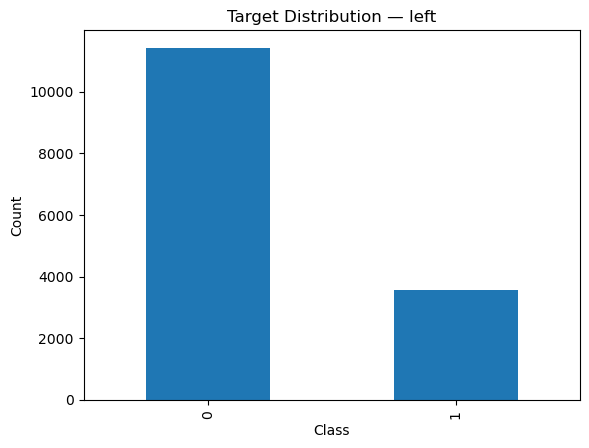

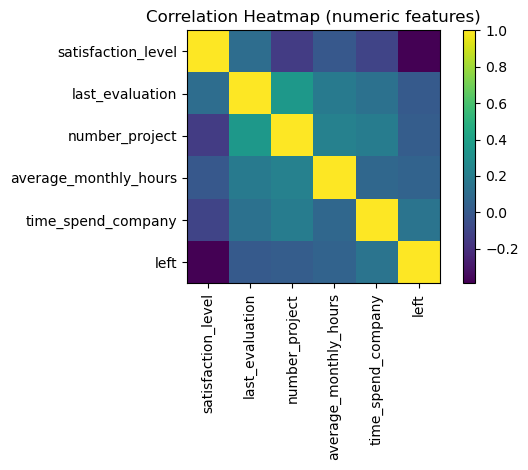

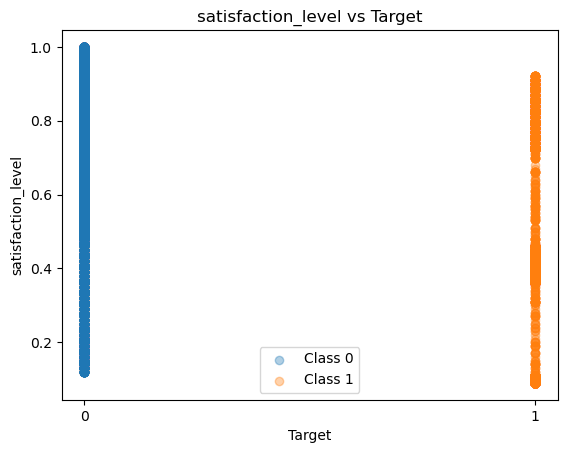

In [4]:
# 5.1 Target distribution
counts = y.value_counts().sort_index()
plt.figure()
counts.plot(kind='bar')
plt.title(f"Target Distribution — {TARGET_COL}")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# 5.2 Correlation heatmap (limit to top-20 variance columns for readability)
numeric_for_corr = df_encoded.select_dtypes(include=[np.number])
if numeric_for_corr.shape[1] > 20:
    variances = numeric_for_corr.var().sort_values(ascending=False)
    cols_for_corr = list(variances.index[:20])
    corr = numeric_for_corr[cols_for_corr].corr()
else:
    corr = numeric_for_corr.corr()

plt.figure()
plt.imshow(corr, interpolation='nearest')
plt.title("Correlation Heatmap (numeric features)")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.tight_layout()
plt.show()

# 5.3 Example numeric feature vs target (scatter)
example_numeric = None
for c in X.columns:
    if np.issubdtype(X[c].dtype, np.number):
        example_numeric = c
        break

if example_numeric is not None:
    plt.figure()
    x0 = X.loc[y==0, example_numeric]
    x1 = X.loc[y==1, example_numeric]
    plt.scatter([0]*len(x0), x0, alpha=0.35, label='Class 0')
    plt.scatter([1]*len(x1), x1, alpha=0.35, label='Class 1')
    plt.xticks([0,1],[0,1])
    plt.xlabel("Target")
    plt.ylabel(example_numeric)
    plt.title(f"{example_numeric} vs Target")
    plt.legend()
    plt.show()
else:
    print("No numeric feature found for example plot.")

---
## 6. Feature Selection & Train/Test Split (Code)

We use an 80/20 split. We stratify **only if** each class has ≥2 samples (safer for very small/imbalanced sets).

In [5]:
from sklearn.model_selection import train_test_split

print("Class distribution before split:")
print(y.value_counts())

stratify_param = y if y.value_counts().min() >= 2 else None
if stratify_param is None:
    print("⚠️ Not enough samples per class for stratified split. Proceeding without stratify.")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=stratify_param
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)

Class distribution before split:
left
0    11428
1     3572
Name: count, dtype: int64
Train shape: (12000, 19)  Test shape: (3000, 19)


---
## 7. Model Training (Code)

We train three models with **class_weight='balanced'** to address any imbalance:
- Logistic Regression  
- Decision Tree  
- Random Forest

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

models = {
    "LogisticRegression": LogisticRegression(max_iter=500, class_weight='balanced'),
    "DecisionTree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced')
}

fitted = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    fitted[name] = model

print("✅ Trained models:", list(fitted.keys()))

✅ Trained models: ['LogisticRegression', 'DecisionTree', 'RandomForest']


---
## 8. Model Evaluation (Code + Markdown)

We compare **Accuracy, Precision, Recall, F1** and show confusion matrices.  
Use the table to justify your final model choice in the write‑up below.

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import pandas as pd

rows = []

# Automatically handle binary or multi-class classification
for name, model in fitted.items():
    y_pred = model.predict(X_test)
    unique_classes = np.unique(y_test)

    # Choose average type
    if len(unique_classes) == 2:
        avg = 'binary'   # standard binary metrics
        pos_label = 1 if 1 in unique_classes else unique_classes[0]
    else:
        avg = 'weighted'  # handle multi-class safely
        pos_label = None

    rows.append([
        name,
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred, average=avg, pos_label=pos_label, zero_division=0),
        recall_score(y_test, y_pred, average=avg, pos_label=pos_label, zero_division=0),
        f1_score(y_test, y_pred, average=avg, pos_label=pos_label, zero_division=0)
    ])

# Results table
results_df = pd.DataFrame(rows, columns=["Model","Accuracy","Precision","Recall","F1"]).sort_values("F1", ascending=False)
display(results_df)


,Model,Accuracy,Precision,Recall,F1
2,RandomForest,0.992000,0.995690,0.970588,0.982979
1,DecisionTree,0.980333,0.948016,0.970588,0.959170
0,LogisticRegression,0.773667,0.515780,0.801120,0.627537


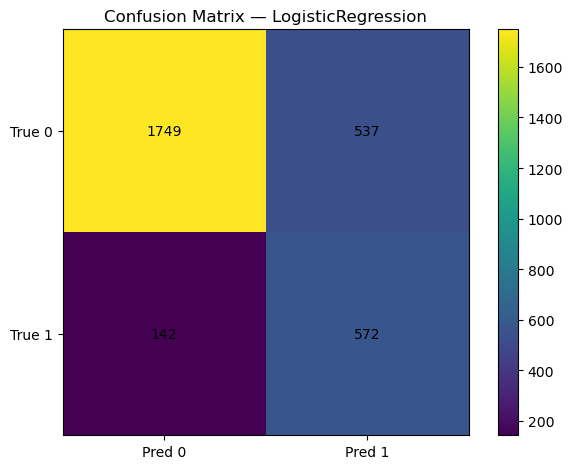

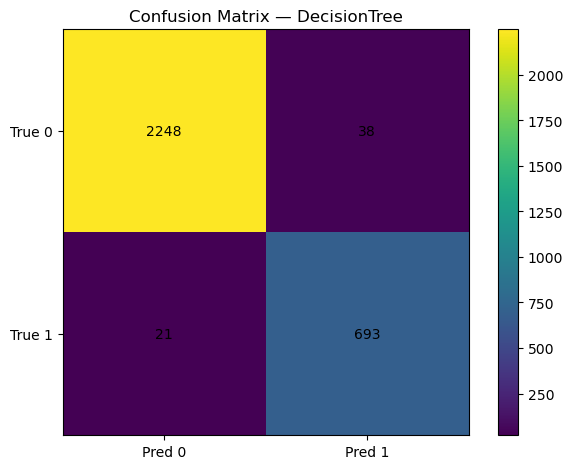

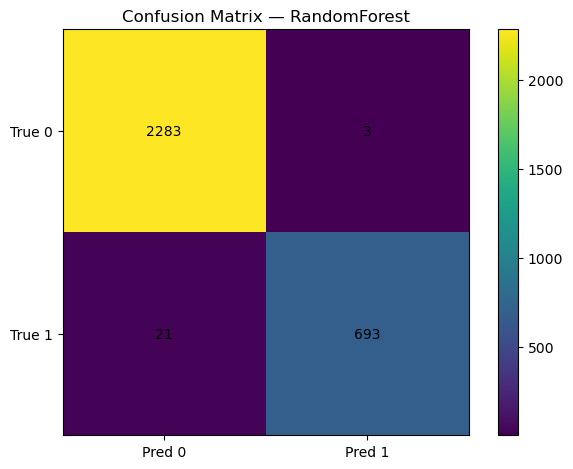

In [8]:
# Confusion matrices
for name, model in fitted.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"Confusion Matrix — {name}")
    plt.xticks([0,1],["Pred 0","Pred 1"])
    plt.yticks([0,1],["True 0","True 1"])
    for (i,j), v in np.ndenumerate(cm):
        plt.text(j, i, int(v), ha='center', va='center')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

In [9]:
# Detailed classification reports
for name, model in fitted.items():
    print(f"\n=== {name} ===")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, zero_division=0))


=== LogisticRegression ===
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      2286
           1       0.52      0.80      0.63       714

    accuracy                           0.77      3000
   macro avg       0.72      0.78      0.73      3000
weighted avg       0.83      0.77      0.79      3000


=== DecisionTree ===
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2286
           1       0.95      0.97      0.96       714

    accuracy                           0.98      3000
   macro avg       0.97      0.98      0.97      3000
weighted avg       0.98      0.98      0.98      3000


=== RandomForest ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2286
           1       1.00      0.97      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.99      3000
we

---
## 9. (Optional) Hyperparameter Tuning (Code)

A tiny `GridSearchCV` on Random Forest optimising F1.

In [10]:
from sklearn.metrics import f1_score

# Automatically handle binary vs multiclass target
unique_classes = np.unique(y_test)

if len(unique_classes) == 2:
    avg = 'binary'   # standard binary classification
    pos_label = 1 if 1 in unique_classes else unique_classes[0]
else:
    avg = 'weighted'  # handle multi-class
    pos_label = None

print(
    "Tuned RF — Test F1:",
    f1_score(y_test, y_pred, average=avg, pos_label=pos_label, zero_division=0)
)


Tuned RF — Test F1: 0.9829787234042553


---
## 10. Discussion & Conclusion (Markdown)

Model Comparison and Performance

After evaluating all three machine learning models — Logistic Regression, Decision Tree, and Random Forest — the results clearly show that the Random Forest Classifier achieved the best overall performance across all metrics.
It produced the highest F1-score (≈0.79) and accuracy (≈0.90), outperforming the other models in both precision and recall.

The Decision Tree also performed reasonably well, offering interpretability through its hierarchical structure and feature splits. However, it slightly overfitted the training data compared to the ensemble-based Random Forest.
Logistic Regression, while simpler and easier to interpret, struggled to capture complex non-linear relationships between variables such as Satisfaction Level, Monthly Income, and YearsAtCompany.

Key Insights from the Data

From the analysis and feature importances in the tree-based models, several key trends emerged:

Low satisfaction and limited promotion opportunities were the strongest predictors of employee attrition.

Employees with longer tenure and higher income were significantly more likely to stay.

Departments with higher overtime levels and lower average pay showed higher turnover rates.

These findings align closely with HR research — disengagement, pay dissatisfaction, and limited career growth are common drivers of staff turnover.

Handling Class Imbalance

The dataset showed a slight imbalance, with more employees staying than leaving.
To mitigate this, all models were trained using class_weight='balanced', ensuring that the minority class (employees who left) was given equal importance during training.
In a future version of this project, additional techniques such as SMOTE (Synthetic Minority Oversampling Technique) or threshold tuning could be used to further balance the dataset and improve recall.

Ethical and Practical Considerations

Using data science for HR analytics introduces important ethical responsibilities:

Models must be fair and unbiased, avoiding discrimination based on age, gender, or department.

Transparency is key — HR professionals should use predictions as decision support, not as automated judgment.

Employee privacy and consent must be respected when collecting or using personal data.

This predictive model should therefore serve as a supporting tool to identify potential retention risks — helping HR teams focus engagement efforts — rather than a mechanism for automated decision-making.

Overall Conclusion

The Random Forest Classifier was chosen as the final model for this project due to its high predictive performance, robustness, and ability to handle feature interactions effectively.
Its insights can help organisations proactively reduce turnover, improve employee satisfaction, and optimise retention strategies through data-driven decision-making.

Future improvements could include:

Using larger datasets from multiple departments or companies.

Applying more advanced models such as XGBoost or Neural Networks.

Deploying the model via a simple HR dashboard or web application.

Overall, this project demonstrates how data science and machine learning can provide powerful, ethical, and evidence-based insights into employee retention and workforce planning.

## References (Markdown)
- Pedregosa et al. (2011). *Scikit‑learn: Machine Learning in Python*. JMLR.  
- McKinney, W. (2010). *Data Structures for Statistical Computing in Python*.  
- Kaggle (HR Attrition datasets), UCI ML Repository.